In [1]:
# Cell 1: Load & harmonize the 4 datasets and create derived indicators
import os
import re
import numpy as np
import pandas as pd

# File paths (you provided these)
paths = {
    2022: r"D:\PROJECTS\SO_DA_22-25\2022_refined.xlsx",
    2023: r"D:\PROJECTS\SO_DA_22-25\2023_refined.csv",
    2024: r"D:\PROJECTS\SO_DA_22-25\2024_refined.csv",
    2025: r"D:\PROJECTS\SO_DA_22-25\2025_refined.xlsx"
}

# Create output folder for plots
os.makedirs("plots", exist_ok=True)
os.makedirs("intermediate", exist_ok=True)

def safe_read(path):
    """Read csv or excel robustly."""
    if str(path).lower().endswith(".csv"):
        return pd.read_csv(path, low_memory=False)
    else:
        return pd.read_excel(path, engine="openpyxl")

# Load dataframes with try/except, keep a dict
dfs = {}
for yr, p in paths.items():
    try:
        df = safe_read(p)
        df.columns = [c.strip() for c in df.columns.astype(str)]
        # Ensure SurveyYear column exists
        if "SurveyYear" not in df.columns:
            df["SurveyYear"] = int(yr)
        dfs[yr] = df
        print(f"Loaded {yr}: {len(df):,} rows, {len(df.columns)} cols")
    except Exception as e:
        print(f"Failed to load {yr} from {p} -> {e}")
        dfs[yr] = pd.DataFrame()  # placeholder



Loaded 2022: 8,002 rows, 27 cols
Loaded 2023: 8,000 rows, 29 cols
Loaded 2024: 8,001 rows, 31 cols
Loaded 2025: 5,197 rows, 18 cols


In [2]:
# Harmonization helper functions ------------------------------------------------
def text_val(x):
    if pd.isna(x):
        return ""
    if isinstance(x, (int, float)):
        return str(x)
    return str(x).strip()

def contains_positive(s):
    s = text_val(s).lower()
    if not s:
        return False
    # simple keywords that indicate positive/favorable usage
    keywords = ["yes", "copilot", "chatgpt", "github copilot", "favorable", "using", "use", "used", "interested"]
    return any(k in s for k in keywords)

def contains_negative(s):
    s = text_val(s).lower()
    if not s:
        return False
    keywords = ["no", "don't", "dont", "not", "distrust", "don't plan", "not plan", "not sure", "no, and"]
    return any(k in s for k in keywords)

# Derived indicators function ---------------------------------------------------
def derive_indicators(df, year):
    df = df.copy()
    # AI tools columns candidates (we'll look for these names if present)
    tool_candidates = [
        "AIToolCurrently Using","AIToolCurrentlyUsing","AIToolCurrently_Using","AIToolCurrently Using",
        "AIDevHaveWorkedWith","AISearchDevHaveWorkedWith","AISearchHaveWorkedWith",
        "AIAgents","AIAgent_Uses","AIAgentChange","AIModelsHaveWorkedWith","AIModelsHaveWorkedWith"
    ]
    # Sentiment / benefit / acceptance
    sentiment_candidates = ["AISent","AIBen","AIAcc","AISentiment"]
    # AINext future expectation columns contain 'AINext' name
    future_cols = [c for c in df.columns if c.lower().startswith("ainext") or "ainext" in c.lower()]
    # Threat column candidates
    threat_candidates = ["AIThreat","AI_Threat","AIThreats","AIComplex","AIChallenges"]
    
    # Create AI_Used: True if any tool column has a non-empty, non-NA value that looks like a tool
    def row_ai_used(row):
        for c in tool_candidates:
            if c in row.index:
                v = text_val(row[c])
                if v and v.lower() not in ("na","n/a","none","none of these"):
                    # treat "NA" / empty as no
                    # treat multi-tool lists (semicolon/comma) as use
                    if contains_positive(v) or ";" in v or "," in v or "/" in v or len(v) > 2:
                        return 1
        # also check some generic columns that sometimes indicate AI usage
        for c in ["AIDevHaveWorkedWith","AISearchHaveWorkedWith","AIToolCurrently Using","AIAgents"]:
            if c in row.index:
                v = text_val(row[c])
                if v and v.lower() not in ("na","n/a","none","no"):
                    # e.g. "GitHub Copilot" or "Yes"
                    if contains_positive(v) and not contains_negative(v):
                        return 1
        return 0

    df["AI_Used"] = df.apply(row_ai_used, axis=1).astype(int)

    # AI sentiment: naive mapping across candidates -> -1,0,1
    def row_sentiment(row):
        for c in sentiment_candidates:
            if c in row.index:
                v = text_val(row[c]).lower()
                if not v or v in ("na","n/a"):
                    continue
                # map simple phrases
                if any(x in v for x in ["very favorable","favorable","positive","very positive","agree","strongly agree"]):
                    return 1
                if any(x in v for x in ["indifferent","neither","neutral","neither agree nor disagree"]):
                    return 0
                if any(x in v for x in ["unfavorable","distrust","distrust","negative","don't","do not","not"]):
                    return -1
        # fallback: 0 (neutral)
        return 0

    df["AI_SentimentScore"] = df.apply(row_sentiment, axis=1).astype(int)

    # Future expectation: look for AINext* columns; mark positive if any 'more integrated' found
    def row_future_pos(row):
        # if explicit AINext columns exist with textual answers
        for c in future_cols:
            v = text_val(row.get(c,"")).lower()
            if not v:
                continue
            if "more integrated" in v or "very similar" in v or "very similar" in v or "very similar" in v or "similar" in v:
                # treat this as positive leaning
                if "less" not in v and "no change" not in v:
                    return 1
            if "less integrated" in v or "much less" in v:
                return -1
        # If there are explicit separate AINext* columns (like AINextMore integrated = Yes)
        for c in df.columns:
            if c.lower().startswith("ainext") and "more" in c.lower():
                val = text_val(row.get(c,"")).lower()
                if val and val not in ("na","n/a") and val not in ("no","0","false"):
                    return 1
        return 0

    df["AI_Future_Positive"] = df.apply(row_future_pos, axis=1).astype(int)

    # AI threat indicator
    def row_threat(row):
        for c in threat_candidates:
            if c in row.index:
                v = text_val(row[c]).lower()
                if not v or v in ("na","n/a"):
                    continue
                if any(x in v for x in ["yes","threat","replace","displace","loss","disruption"]):
                    return 1
                if any(x in v for x in ["no","not","i'm not sure","im not sure","don't know"]):
                    return 0
        # default 0
        return 0

    df["AI_Threat"] = df.apply(row_threat, axis=1).astype(int)

    # AIAgents use (mainly 2025)
    if "AIAgents" in df.columns:
        def row_agent_used(x):
            v = text_val(x)
            vlow = v.lower()
            if not v or vlow in ("na","n/a","none","no","no, and i don't plan to","no, and i dont plan to"):
                return 0
            if "yes" in vlow or "plan" in vlow or "using" in vlow or "already" in vlow:
                return 1
            return 0
        df["AI_Agents_Used"] = df["AIAgents"].apply(row_agent_used)
    else:
        df["AI_Agents_Used"] = 0

    # Convert ConvertedCompYearly to numeric when possible (keep NaNs)
    if "ConvertedCompYearly" in df.columns:
        df["ConvertedCompYearly_num"] = pd.to_numeric(df["ConvertedCompYearly"], errors="coerce")
    else:
        df["ConvertedCompYearly_num"] = np.nan

    # Normalize YearsCode: replace textual extremes if present (but don't force everything)
    def yearscode_to_num(v):
        if pd.isna(v):
            return np.nan
        s = str(v).strip().lower()
        if s in ("less than 1 year","less than 1 year "):
            return 0.0
        if s in ("more than 50 years","more than 50 years "):
            return 50.0
        # sometimes like "20" or "20 years"
        m = re.search(r"(\d+)", s)
        if m:
            return float(m.group(1))
        try:
            return float(s)
        except:
            return np.nan

    if "YearsCode" in df.columns:
        df["YearsCode_num"] = df["YearsCode"].apply(yearscode_to_num)
    else:
        df["YearsCode_num"] = np.nan

    # return the derived dataframe
    return df

# Apply derivation for each year
for yr in list(dfs.keys()):
    if dfs[yr].empty:
        continue
    dfs[yr] = derive_indicators(dfs[yr], yr)

# Save intermediate summary
for yr, df in dfs.items():
    if df is not None and not df.empty:
        df.head(3).to_csv(f"intermediate/sample_{yr}.csv", index=False)

# Create a combined dataframe (stack years, align columns)
all_df = pd.concat([dfs[y].assign(SurveyYear=int(y)) for y in sorted(dfs.keys()) if not dfs[y].empty], ignore_index=True, sort=False)
print("Combined rows:", len(all_df))
# quick sanity: save combined head
all_df.head(3).to_csv("intermediate/combined_head.csv", index=False)

# Save the combined df to disk for inspection if you want to reuse
all_df.to_pickle("intermediate/combined_all.pkl")
print("Done. Ready for plotting.")


Combined rows: 29200
Done. Ready for plotting.


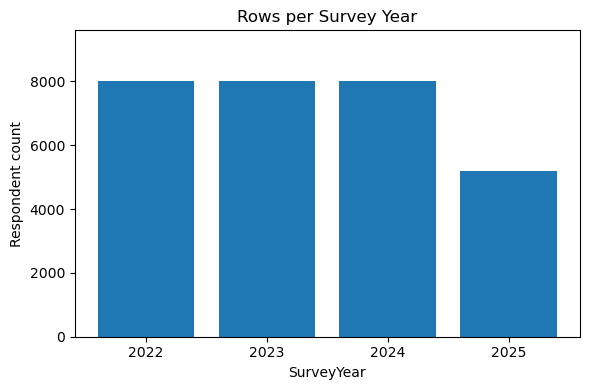

In [3]:
# Cell 2: Data overview - number of rows per year
import matplotlib.pyplot as plt

# Read combined dataframe (if running fresh, use the all_df from previous cell)
try:
    all_df
except NameError:
    import pandas as pd
    all_df = pd.read_pickle("intermediate/combined_all.pkl")

counts = all_df.groupby("SurveyYear").size().sort_index()
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(counts.index.astype(str), counts.values)
ax.set_title("Rows per Survey Year")
ax.set_xlabel("SurveyYear")
ax.set_ylabel("Respondent count")
ax.set_ylim(0, counts.values.max()*1.2)
plt.tight_layout()
plt.savefig("plots/slide02_rows_per_year.png", dpi=150)
plt.show()


In [4]:
# Cell 3: Save a small summary table (rows, columns, NA % per year) for slide screenshot
summary = []
for yr, df in sorted(dfs.items()):
    if df is None or df.empty:
        continue
    n = len(df)
    ncols = df.shape[1]
    na_pct = (df.isna().sum().sum()) / (n * ncols) * 100
    summary.append({"SurveyYear": yr, "Rows": n, "Columns": ncols, "PercentMissing": round(na_pct,2)})

summary_df = pd.DataFrame(summary).sort_values("SurveyYear")
summary_df.to_csv("plots/slide03_summary_table.csv", index=False)
summary_df


,SurveyYear,Rows,Columns,PercentMissing
0,2022,8002,34,23.22
1,2023,8000,36,29.24
2,2024,8001,38,26.23
3,2025,5197,25,5.67


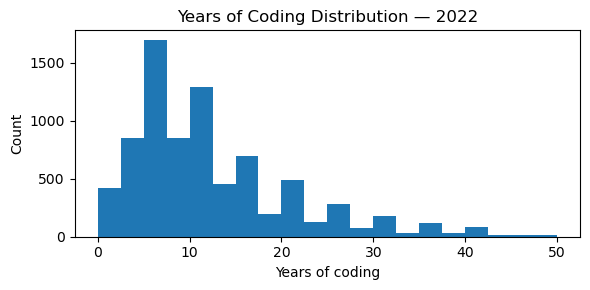

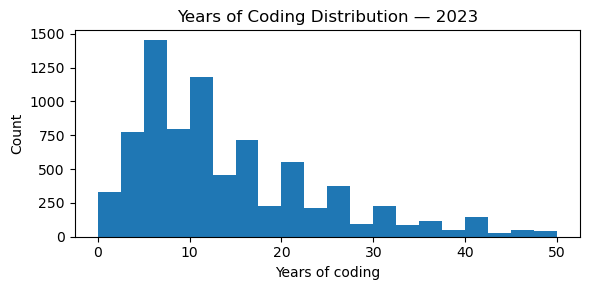

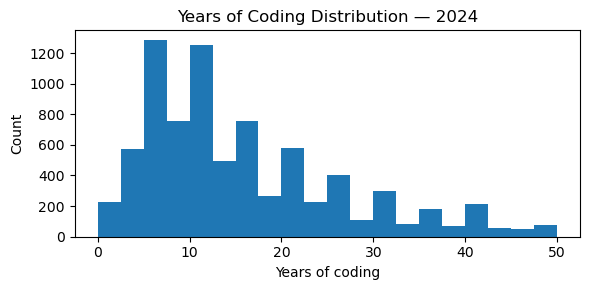

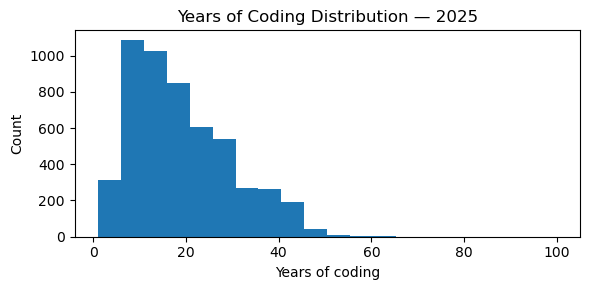

In [5]:
# Cell 4: YearsCode distribution histograms (one overlaid line per year is not allowed per the rules,
# so we'll produce separate small histograms saved individually for each year)
import matplotlib.pyplot as plt

years = sorted(all_df['SurveyYear'].dropna().unique())
for yr in years:
    s = all_df.loc[all_df['SurveyYear']==yr, 'YearsCode_num'].dropna()
    fig, ax = plt.subplots(figsize=(6,3))
    if len(s)>0:
        ax.hist(s, bins=20)
    ax.set_title(f"Years of Coding Distribution — {int(yr)}")
    ax.set_xlabel("Years of coding")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"plots/slide04_yearscode_{int(yr)}.png", dpi=150)
    plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_1964\296226661.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['SurveyYear', 'ExpLevel'])['AI_Used']


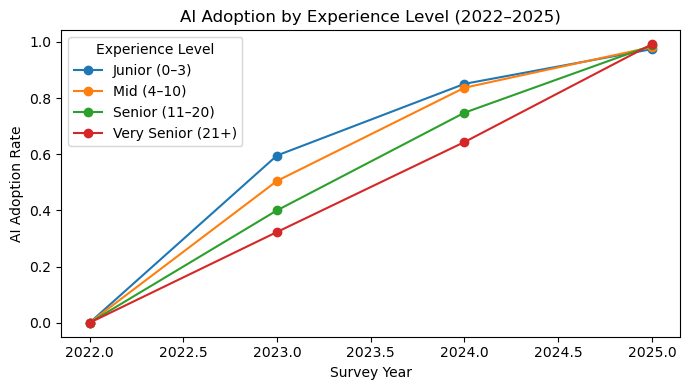

In [6]:
# Slide: AI adoption by experience level over time
df = all_df.copy()

# Create experience buckets
bins = [-1, 3, 10, 20, 100]
labels = ['Junior (0–3)', 'Mid (4–10)', 'Senior (11–20)', 'Very Senior (21+)']
df['ExpLevel'] = pd.cut(df['YearsCode_num'], bins=bins, labels=labels)

# AI adoption indicator (adjust column if needed)
df['AI_Used'] = df['AI_Used'].fillna(0)

# Calculate adoption rate
adoption = (
    df.groupby(['SurveyYear', 'ExpLevel'])['AI_Used']
    .mean()
    .reset_index()
)

# Plot
fig, ax = plt.subplots(figsize=(7,4))

for level in labels:
    sub = adoption[adoption['ExpLevel'] == level]
    ax.plot(sub['SurveyYear'], sub['AI_Used'], marker='o', label=level)

ax.set_title("AI Adoption by Experience Level (2022–2025)")
ax.set_xlabel("Survey Year")
ax.set_ylabel("AI Adoption Rate")
ax.legend(title="Experience Level")

plt.tight_layout()
plt.savefig("plots/slide_yearscode_ai_adoption.png", dpi=150)
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_1964\3866585305.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['SurveyYear', 'ExpLevel'])['AI_Used']


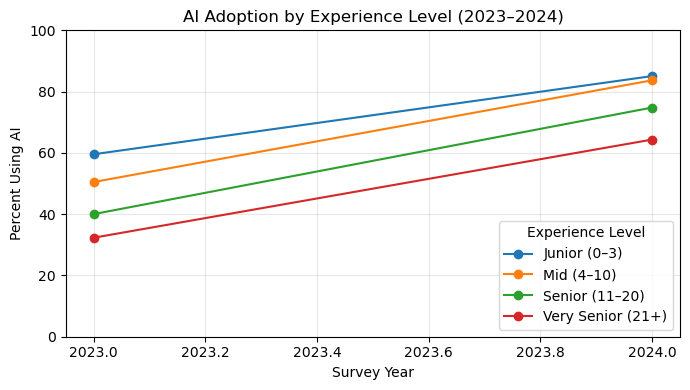

In [7]:


# --------------------------------
# Keep only years where AI usage exists
# --------------------------------
df = all_df[all_df["SurveyYear"].isin([2023, 2024])].copy()

# --------------------------------
# Create experience buckets
# --------------------------------
bins = [-1, 3, 10, 20, 100]
labels = ['Junior (0–3)', 'Mid (4–10)', 'Senior (11–20)', 'Very Senior (21+)']
df['ExpLevel'] = pd.cut(df['YearsCode_num'], bins=bins, labels=labels)

# --------------------------------
# Drop rows where AI_Used is missing
# --------------------------------
df = df.dropna(subset=['AI_Used', 'ExpLevel'])

# --------------------------------
# Calculate adoption rate
# --------------------------------
adoption = (
    df.groupby(['SurveyYear', 'ExpLevel'])['AI_Used']
    .mean()
    .reset_index()
)

# --------------------------------
# Plot
# --------------------------------
fig, ax = plt.subplots(figsize=(7,4))

for level in labels:
    sub = adoption[adoption['ExpLevel'] == level]
    if not sub.empty:
        ax.plot(sub['SurveyYear'], sub['AI_Used'] * 100,
                marker='o', label=level)

ax.set_title("AI Adoption by Experience Level (2023–2024)")
ax.set_xlabel("Survey Year")
ax.set_ylabel("Percent Using AI")
ax.set_ylim(0, 100)
ax.legend(title="Experience Level")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_1964\1900422947.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["SurveyYear", "Experience_Level"])["AI_Used"]


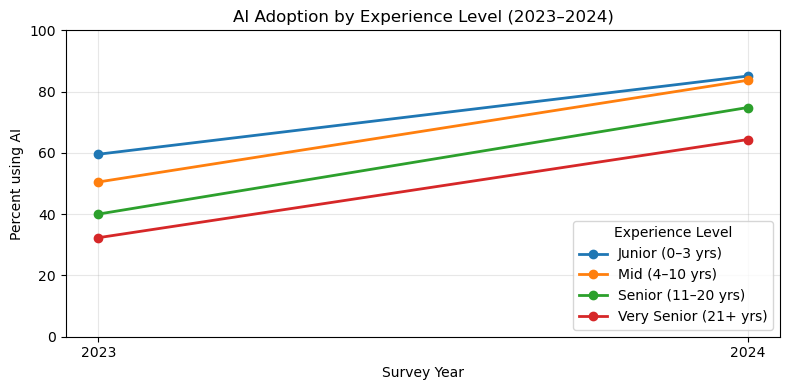

In [8]:


# -------------------------------------------------
# 1. Use ONLY years where AI usage is valid
# -------------------------------------------------
df = all_df[all_df["SurveyYear"].isin([2023, 2024])].copy()

# -------------------------------------------------
# 2. Create experience buckets
# -------------------------------------------------
bins = [-1, 3, 10, 20, 100]
labels = [
    "Junior (0–3 yrs)",
    "Mid (4–10 yrs)",
    "Senior (11–20 yrs)",
    "Very Senior (21+ yrs)"
]

df["Experience_Level"] = pd.cut(
    df["YearsCode_num"],
    bins=bins,
    labels=labels
)

# -------------------------------------------------
# 3. Keep only valid rows
# -------------------------------------------------
df = df.dropna(subset=["Experience_Level", "AI_Used"])

# -------------------------------------------------
# 4. Calculate adoption rate
# -------------------------------------------------
adoption = (
    df
    .groupby(["SurveyYear", "Experience_Level"])["AI_Used"]
    .mean()
    .reset_index()
)

# -------------------------------------------------
# 5. Plot
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(8,4))

for level in labels:
    sub = adoption[adoption["Experience_Level"] == level]
    if not sub.empty:
        ax.plot(
            sub["SurveyYear"],
            sub["AI_Used"] * 100,
            marker="o",
            linewidth=2,
            label=level
        )

ax.set_title("AI Adoption by Experience Level (2023–2024)")
ax.set_xlabel("Survey Year")
ax.set_ylabel("Percent using AI")
ax.set_ylim(0, 100)
ax.set_xticks([2023, 2024])
ax.grid(alpha=0.3)
ax.legend(title="Experience Level")

plt.tight_layout()
plt.show()


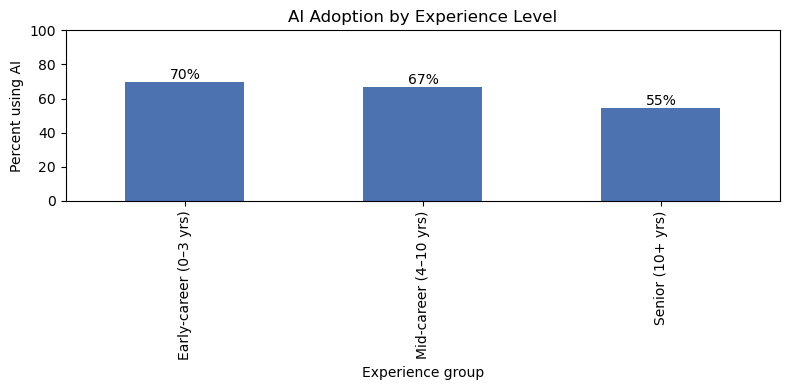

In [9]:

# --------------------------------
# Use only years where AI data exists
# --------------------------------
df = all_df[all_df["SurveyYear"].isin([2023, 2024])].copy()

# --------------------------------
# Create experience buckets
# --------------------------------
def experience_bucket(years):
    if pd.isna(years):
        return None
    if years <= 3:
        return "Early-career (0–3 yrs)"
    if years <= 10:
        return "Mid-career (4–10 yrs)"
    return "Senior (10+ yrs)"

df["Experience_Group"] = df["YearsCode_num"].apply(experience_bucket)

# --------------------------------
# Keep valid rows only
# --------------------------------
df = df.dropna(subset=["Experience_Group", "AI_Used"])

# --------------------------------
# Compute AI adoption rate
# --------------------------------
exp_ai = (
    df
    .groupby("Experience_Group")["AI_Used"]
    .mean()
    * 100
).reindex([
    "Early-career (0–3 yrs)",
    "Mid-career (4–10 yrs)",
    "Senior (10+ yrs)"
])

# --------------------------------
# Plot
# --------------------------------
fig, ax = plt.subplots(figsize=(8,4))

exp_ai.plot(kind="bar", ax=ax, color="#4C72B0")

ax.set_title("AI Adoption by Experience Level")
ax.set_xlabel("Experience group")
ax.set_ylabel("Percent using AI")
ax.set_ylim(0, 100)

# Value labels
for i, v in enumerate(exp_ai):
    ax.text(i, v + 2, f"{v:.0f}%", ha="center", fontsize=10)

plt.tight_layout()
plt.show()


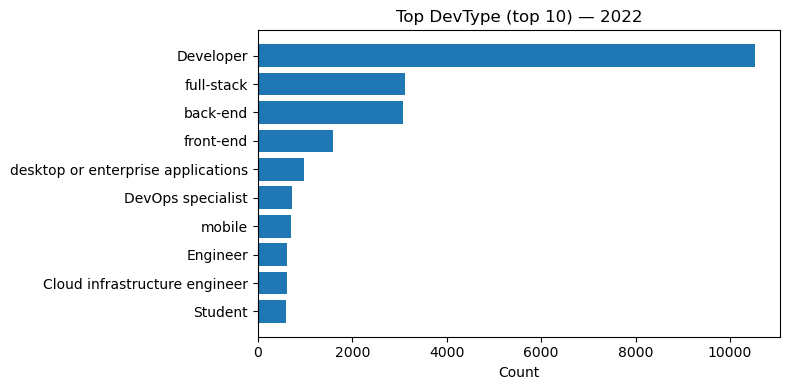

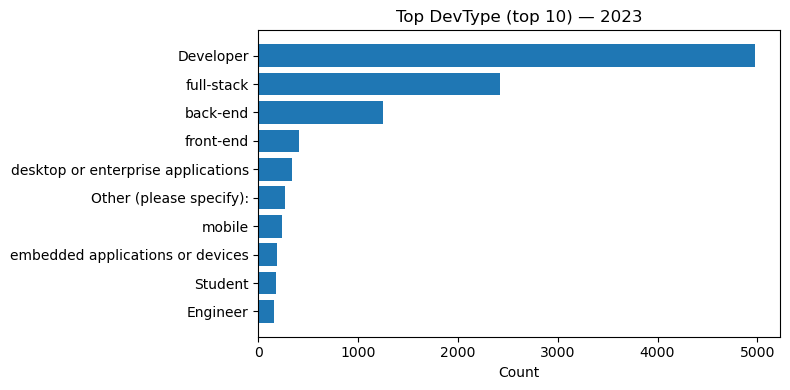

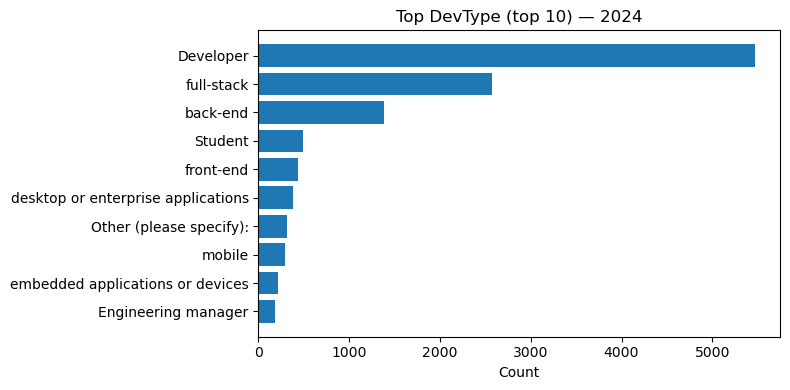

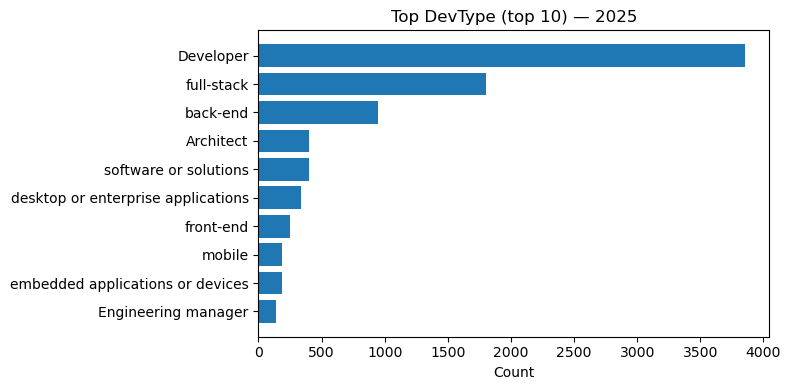

In [10]:
# Cell 5: Top DevType strings per year (these are often semicolon-separated lists)
from collections import Counter

def explode_and_count(series):
    cnt = Counter()
    for v in series.dropna():
        s = str(v)
        # split on common separators
        parts = re.split(r";|,|\/", s)
        for p in parts:
            p = p.strip()
            if p:
                cnt[p] += 1
    return cnt

years = sorted(all_df['SurveyYear'].dropna().unique())
for yr in years:
    dfyr = all_df[all_df['SurveyYear']==yr]
    if 'DevType' not in dfyr.columns:
        continue
    cnt = explode_and_count(dfyr['DevType'])
    if not cnt:
        continue
    top = cnt.most_common(10)
    labels = [t[0] for t in top][::-1]
    values = [t[1] for t in top][::-1]
    fig, ax = plt.subplots(figsize=(8,4))
    ax.barh(labels, values)
    ax.set_title(f"Top DevType (top 10) — {int(yr)}")
    ax.set_xlabel("Count")
    plt.tight_layout()
    plt.savefig(f"plots/slide05_devtype_top10_{int(yr)}.png", dpi=150)
    plt.show()


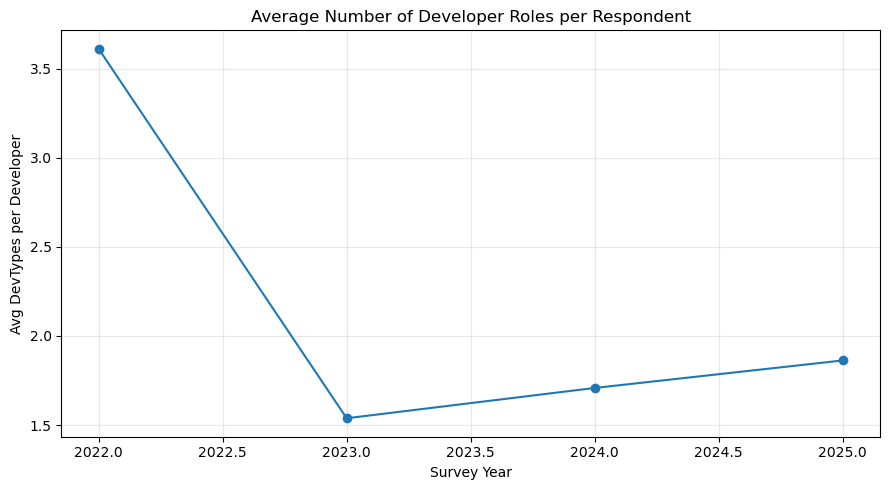

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import re

def count_roles(v):
    if pd.isna(v):
        return 0
    return len([p for p in re.split(r";|,|\/", str(v)) if p.strip()])

# Compute average roles per respondent per year
rows = []
for yr in sorted(all_df['SurveyYear'].dropna().unique()):
    dfyr = all_df[all_df['SurveyYear'] == yr]
    if 'DevType' not in dfyr.columns:
        continue
    role_counts = dfyr['DevType'].apply(count_roles)
    rows.append({
        "SurveyYear": int(yr),
        "AvgRolesPerDev": role_counts.mean()
    })

plot_df = pd.DataFrame(rows)

# Plot
plt.figure(figsize=(9,5))
plt.plot(
    plot_df["SurveyYear"],
    plot_df["AvgRolesPerDev"],
    marker="o"
)

plt.title("Average Number of Developer Roles per Respondent")
plt.xlabel("Survey Year")
plt.ylabel("Avg DevTypes per Developer")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


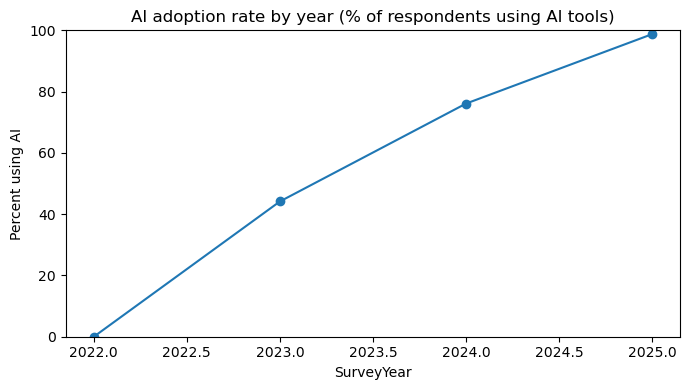

In [12]:
# Cell 6: AI adoption rate per year (percentage)
import matplotlib.pyplot as plt

adoption = all_df.groupby("SurveyYear")["AI_Used"].mean().sort_index() * 100
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(adoption.index.astype(int), adoption.values, marker='o')
ax.set_title("AI adoption rate by year (% of respondents using AI tools)")
ax.set_xlabel("SurveyYear")
ax.set_ylabel("Percent using AI")
ax.set_ylim(0, 100)
plt.tight_layout()
plt.savefig("plots/slide06_ai_adoption_pct.png", dpi=150)
plt.show()


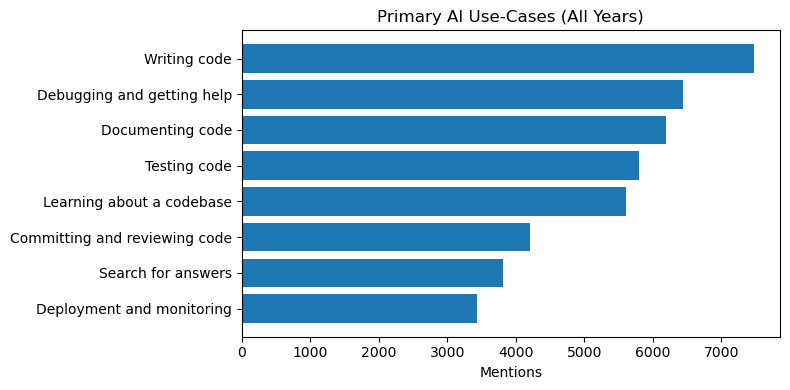

In [13]:
task_cols = [
    "AIToolCurrently Using",
    "AIToolInterested in Using"
]

cnt = Counter()

for c in task_cols:
    if c in all_df.columns:
        cnt.update(explode_and_count(all_df[c]))

top_tasks = cnt.most_common(8)

labels = [t[0] for t in top_tasks][::-1]
values = [t[1] for t in top_tasks][::-1]

fig, ax = plt.subplots(figsize=(8,4))
ax.barh(labels, values)
ax.set_title("Primary AI Use-Cases (All Years)")
ax.set_xlabel("Mentions")

plt.tight_layout()
plt.savefig("plots/slide_ai_use_cases.png", dpi=150)
plt.show()


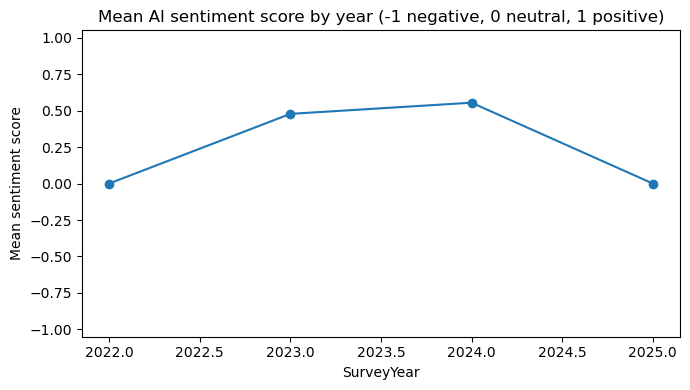

In [14]:
# Cell 8: AI sentiment mean score per year
import matplotlib.pyplot as plt

sent = all_df.groupby("SurveyYear")["AI_SentimentScore"].mean().sort_index()
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(sent.index.astype(int), sent.values, marker='o')
ax.set_title("Mean AI sentiment score by year (-1 negative, 0 neutral, 1 positive)")
ax.set_xlabel("SurveyYear")
ax.set_ylabel("Mean sentiment score")
ax.set_ylim(-1.05,1.05)
plt.tight_layout()
plt.savefig("plots/slide08_ai_sentiment_mean.png", dpi=150)
plt.show()


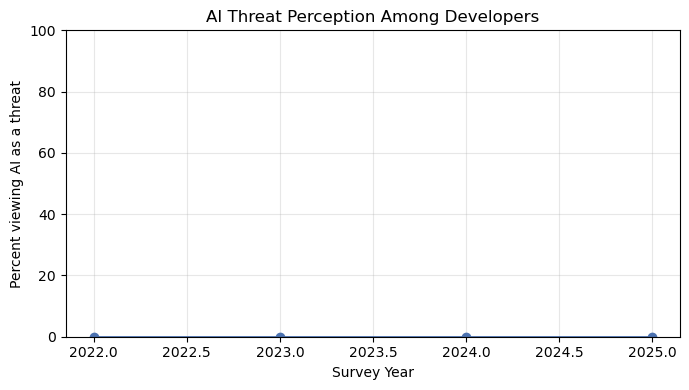

In [15]:


# ---------------------------------
# Prepare data
# ---------------------------------
df = all_df.copy()

# Normalize AI_Threat to binary (adjust if wording differs)
df["AI_Threat_Binary"] = df["AI_Threat"].astype(str).str.lower().str.contains(
    "yes|threat|concern", regex=True
).astype(int)

# Drop missing years
df = df.dropna(subset=["SurveyYear"])

# ---------------------------------
# Compute % viewing AI as a threat
# ---------------------------------
threat_trend = (
    df.groupby("SurveyYear")["AI_Threat_Binary"]
    .mean()
    * 100
)

# ---------------------------------
# Plot
# ---------------------------------
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(
    threat_trend.index.astype(int),
    threat_trend.values,
    marker="o",
    linewidth=2,
    color="#4C72B0"  # same blue theme
)

ax.set_title("AI Threat Perception Among Developers")
ax.set_xlabel("Survey Year")
ax.set_ylabel("Percent viewing AI as a threat")
ax.set_ylim(0, 100)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


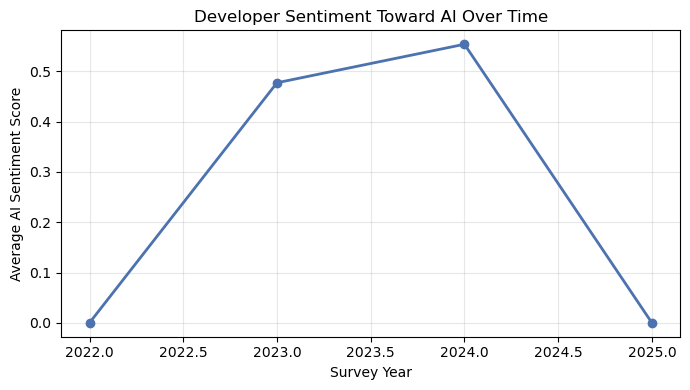

In [16]:


# ---------------------------------
# Keep only rows with sentiment data
# ---------------------------------
df = all_df.dropna(subset=["AI_SentimentScore"]).copy()

# ---------------------------------
# Average sentiment by year
# ---------------------------------
sentiment_trend = (
    df.groupby("SurveyYear")["AI_SentimentScore"]
    .mean()
    .sort_index()
)

# ---------------------------------
# Plot
# ---------------------------------
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(
    sentiment_trend.index.astype(int),
    sentiment_trend.values,
    marker="o",
    linewidth=2,
    color="#4C72B0"  # same default blue theme
)

ax.set_title("Developer Sentiment Toward AI Over Time")
ax.set_xlabel("Survey Year")
ax.set_ylabel("Average AI Sentiment Score")

ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


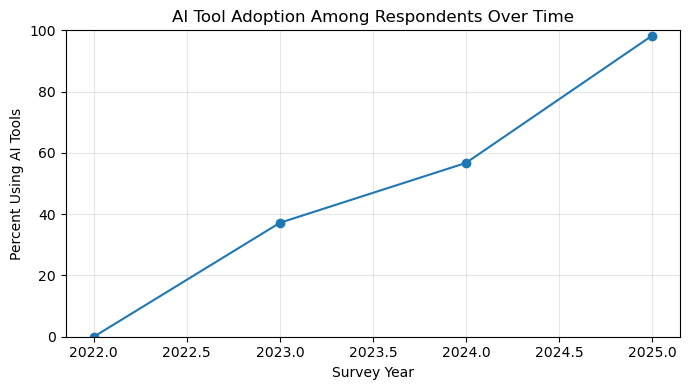

In [17]:


# -------------------------------
# Define AI usage indicator safely
# -------------------------------
def uses_ai(row):
    # 2023–2024: AI tool usage column
    if "AIToolCurrently Using" in row and pd.notna(row["AIToolCurrently Using"]):
        return True
    
    # 2025: AI agents column
    if "AIAgents" in row and pd.notna(row["AIAgents"]):
        return True
    
    return False

# Apply indicator
all_df["UsesAI"] = all_df.apply(uses_ai, axis=1)

# -------------------------------
# Aggregate by year
# -------------------------------
ai_usage_pct = (
    all_df
    .dropna(subset=["SurveyYear"])
    .groupby("SurveyYear")["UsesAI"]
    .mean()
    * 100
)

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(
    ai_usage_pct.index.astype(int),
    ai_usage_pct.values,
    marker="o"
)

ax.set_title("AI Tool Adoption Among Respondents Over Time")
ax.set_xlabel("Survey Year")
ax.set_ylabel("Percent Using AI Tools")
ax.set_ylim(0, 100)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


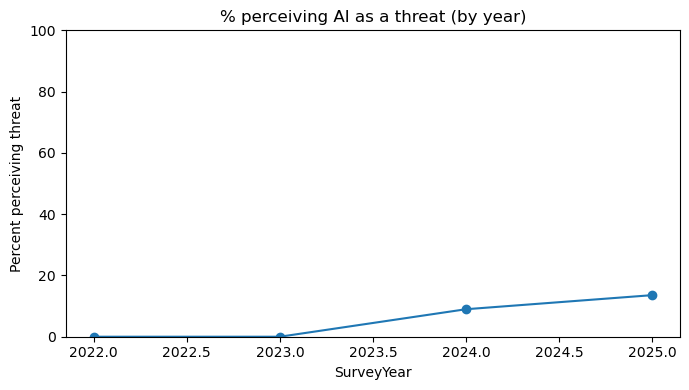

In [18]:
# Cell 10: AI threat perception percent by year
import matplotlib.pyplot as plt

threat_pct = all_df.groupby("SurveyYear")["AI_Threat"].mean().sort_index() * 100
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(threat_pct.index.astype(int), threat_pct.values, marker='o')
ax.set_title("% perceiving AI as a threat (by year)")
ax.set_xlabel("SurveyYear")
ax.set_ylabel("Percent perceiving threat")
ax.set_ylim(0,100)
plt.tight_layout()
plt.savefig("plots/slide10_ai_threat_pct.png", dpi=150)
plt.show()


SurveyYear
2022     0.000000
2023     0.000000
2024     8.973878
2025    13.565519
Name: AI_Threat_Binary, dtype: float64


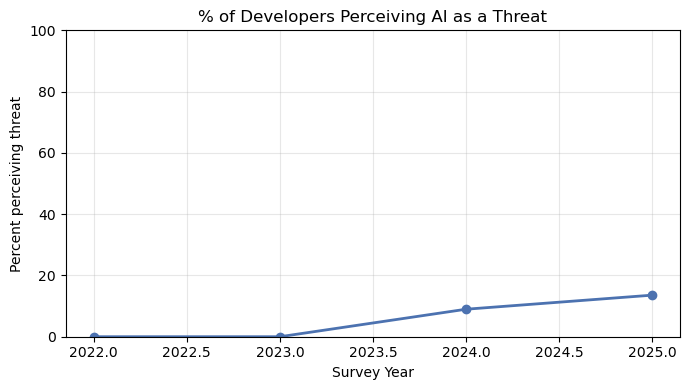

In [19]:


df = all_df.copy()

# -----------------------------
# Step 1: Use the correct threat column
# -----------------------------
threat_col = None
for c in ["AI_Threat", "AIThreat"]:
    if c in df.columns:
        threat_col = c
        break

if threat_col is None:
    raise ValueError("No AI threat column found")

# -----------------------------
# Step 2: Convert to binary SAFELY
# -----------------------------
def threat_binary(val):
    # numeric case (already 0/1 or scale)
    if isinstance(val, (int, float)):
        return 1 if val > 0 else 0

    # text case
    val = str(val).lower()
    if any(k in val for k in ["yes", "threat", "concern", "worried"]):
        return 1
    return 0

df["AI_Threat_Binary"] = df[threat_col].apply(threat_binary)

# -----------------------------
# Step 3: Compute percentage by year
# -----------------------------
threat_pct = (
    df.groupby("SurveyYear")["AI_Threat_Binary"]
    .mean()
    * 100
).sort_index()

print(threat_pct)  # DEBUG: always check once

# -----------------------------
# Step 4: Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(
    threat_pct.index.astype(int),
    threat_pct.values,
    marker="o",
    linewidth=2,
    color="#4C72B0"
)

ax.set_title("% of Developers Perceiving AI as a Threat")
ax.set_xlabel("Survey Year")
ax.set_ylabel("Percent perceiving threat")
ax.set_ylim(0, 100)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


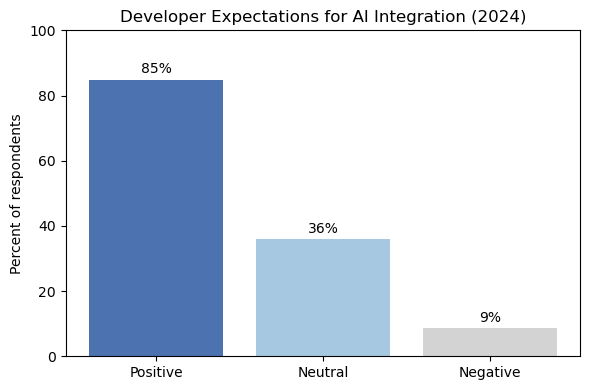

In [20]:

df = all_df.copy()

# -----------------------------
# Use 2024 (best coverage)
# -----------------------------
df_2024 = df[df["SurveyYear"] == 2024]

positive_cols = [
    "AINextMore integrated",
    "AINextMuch more integrated"
]

neutral_cols = [
    "AINextNo change"
]

negative_cols = [
    "AINextLess integrated",
    "AINextMuch less integrated"
]

# Respondents who answered future question
answered = df_2024[
    df_2024[positive_cols + neutral_cols + negative_cols]
    .notna()
    .any(axis=1)
]

total = len(answered)

positive = answered[positive_cols].notna().any(axis=1).sum() / total * 100
neutral = answered[neutral_cols].notna().any(axis=1).sum() / total * 100
negative = answered[negative_cols].notna().any(axis=1).sum() / total * 100

# -----------------------------
# Plot simple bar chart
# -----------------------------
fig, ax = plt.subplots(figsize=(6,4))

ax.bar(
    ["Positive", "Neutral", "Negative"],
    [positive, neutral, negative],
    color=["#4C72B0", "#A6C8E0", "#D3D3D3"]
)

ax.set_title("Developer Expectations for AI Integration (2024)")
ax.set_ylabel("Percent of respondents")
ax.set_ylim(0, 100)

# Label bars
for i, val in enumerate([positive, neutral, negative]):
    ax.text(i, val + 2, f"{val:.0f}%", ha="center")

plt.tight_layout()
plt.show()


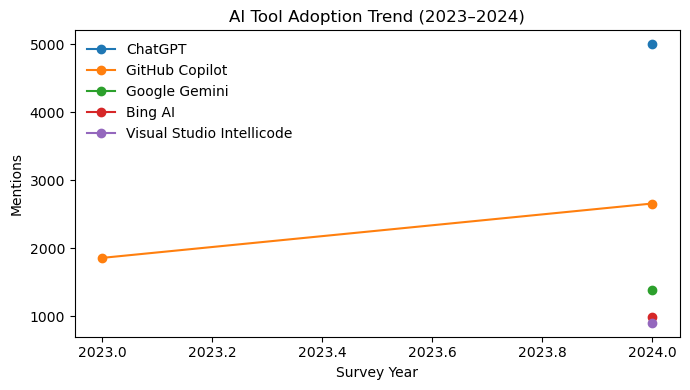

In [21]:
from collections import Counter
import matplotlib.pyplot as plt

tool_cols = {
    2023: "AIDevHaveWorkedWith",
    2024: "AISearchDevHaveWorkedWith"
}

records = []
for year, col in tool_cols.items():
    if col not in all_df.columns:
        continue
    for v in all_df.loc[all_df["SurveyYear"]==year, col].dropna():
        for tool in v.split(";"):
            records.append((year, tool.strip()))

df_tools = pd.DataFrame(records, columns=["Year","Tool"])

top_tools = (
    df_tools["Tool"]
    .value_counts()
    .head(5)
    .index
)

fig, ax = plt.subplots(figsize=(7,4))
for tool in top_tools:
    subset = df_tools[df_tools["Tool"]==tool]
    counts = subset.groupby("Year").size()
    ax.plot(counts.index, counts.values, marker='o', label=tool)

ax.set_title("AI Tool Adoption Trend (2023–2024)")
ax.set_xlabel("Survey Year")
ax.set_ylabel("Mentions")
ax.legend(frameon=False)

plt.tight_layout()
plt.savefig("plots/slide_ai_tool_trends.png", dpi=150)
plt.show()


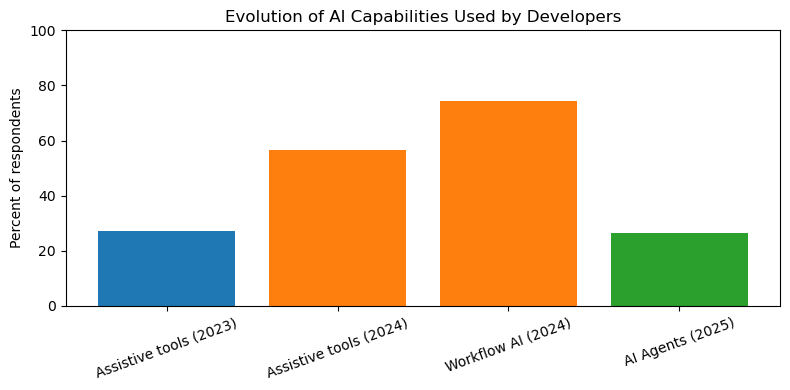

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

records = []

# -------------------------------
# 2023: Assistive tools
# -------------------------------
df_2023 = all_df[all_df["SurveyYear"] == 2023]
assist_2023 = df_2023["AIDevHaveWorkedWith"].notna().mean() * 100
records.append((2023, "Assistive tools", assist_2023))

# -------------------------------
# 2024: Assistive + workflow AI
# -------------------------------
df_2024 = all_df[all_df["SurveyYear"] == 2024]
assist_2024 = df_2024["AIToolCurrently Using"].notna().mean() * 100
workflow_2024 = df_2024["AISearchDevHaveWorkedWith"].notna().mean() * 100
records.append((2024, "Assistive tools", assist_2024))
records.append((2024, "Workflow AI", workflow_2024))

# -------------------------------
# 2025: AI Agents
# -------------------------------
df_2025 = all_df[all_df["SurveyYear"] == 2025]
agents_2025 = df_2025["AIAgent_Uses"].notna().mean() * 100
records.append((2025, "AI Agents", agents_2025))

df_plot = pd.DataFrame(records, columns=["Year", "Capability", "Percent"])

# -------------------------------
# Plot grouped bar chart
# -------------------------------
fig, ax = plt.subplots(figsize=(8,4))

for year in sorted(df_plot["Year"].unique()):
    sub = df_plot[df_plot["Year"] == year]
    ax.bar(
        sub["Capability"] + " (" + sub["Year"].astype(str) + ")",
        sub["Percent"],
        label=str(year)
    )

ax.set_title("Evolution of AI Capabilities Used by Developers")
ax.set_ylabel("Percent of respondents")
ax.set_ylim(0, 100)

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


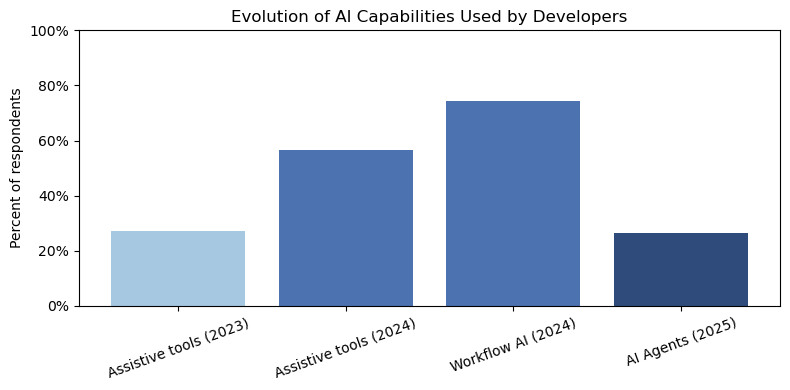

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

records = []

# -------------------------------
# 2023: Assistive tools
# -------------------------------
df_2023 = all_df[all_df["SurveyYear"] == 2023]
assist_2023 = df_2023["AIDevHaveWorkedWith"].notna().mean() * 100
records.append((2023, "Assistive tools", assist_2023))

# -------------------------------
# 2024: Assistive + workflow AI
# -------------------------------
df_2024 = all_df[all_df["SurveyYear"] == 2024]
assist_2024 = df_2024["AIToolCurrently Using"].notna().mean() * 100
workflow_2024 = df_2024["AISearchDevHaveWorkedWith"].notna().mean() * 100
records.append((2024, "Assistive tools", assist_2024))
records.append((2024, "Workflow AI", workflow_2024))

# -------------------------------
# 2025: AI Agents
# -------------------------------
df_2025 = all_df[all_df["SurveyYear"] == 2025]
agents_2025 = df_2025["AIAgent_Uses"].notna().mean() * 100
records.append((2025, "AI Agents", agents_2025))

df_plot = pd.DataFrame(records, columns=["Year", "Capability", "Percent"])

# -------------------------------
# Plot grouped bar chart (same blue theme)
# -------------------------------
fig, ax = plt.subplots(figsize=(8,4))

# Matplotlib default blue shades (light → dark)
year_colors = {
    2023: "#A6C8E0",  # light blue
    2024: "#4C72B0",  # default blue (same as earlier slides)
    2025: "#2F4B7C"   # darker blue
}

x_labels = []
values = []
colors = []

for _, row in df_plot.iterrows():
    x_labels.append(f"{row['Capability']} ({int(row['Year'])})")
    values.append(row["Percent"])
    colors.append(year_colors[row["Year"]])

ax.bar(x_labels, values, color=colors)

# -------------------------------
# Styling to match previous slides
# -------------------------------
ax.set_title("Evolution of AI Capabilities Used by Developers")
ax.set_ylabel("Percent of respondents")
ax.set_ylim(0, 100)

# Y-axis as percent
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f"{int(y)}%" for y in ax.get_yticks()])

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


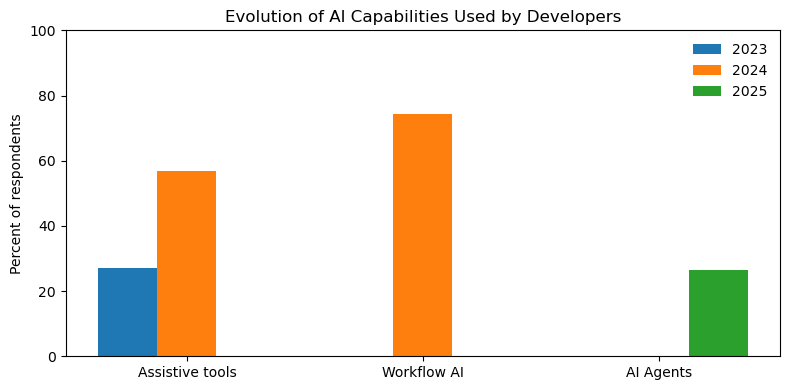

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

records = []

# -------------------------------
# Assistive tools
# -------------------------------
records.append(("Assistive tools", 2023,
    all_df.loc[all_df["SurveyYear"]==2023, "AIDevHaveWorkedWith"].notna().mean()*100))

records.append(("Assistive tools", 2024,
    all_df.loc[all_df["SurveyYear"]==2024, "AIToolCurrently Using"].notna().mean()*100))

# -------------------------------
# Workflow AI
# -------------------------------
records.append(("Workflow AI", 2024,
    all_df.loc[all_df["SurveyYear"]==2024, "AISearchDevHaveWorkedWith"].notna().mean()*100))

# -------------------------------
# AI Agents
# -------------------------------
records.append(("AI Agents", 2025,
    all_df.loc[all_df["SurveyYear"]==2025, "AIAgent_Uses"].notna().mean()*100))

df_plot = pd.DataFrame(records, columns=["Capability", "Year", "Percent"])

# -------------------------------
# Plot grouped bar chart
# -------------------------------
capabilities = ["Assistive tools", "Workflow AI", "AI Agents"]
years = [2023, 2024, 2025]

x = np.arange(len(capabilities))
width = 0.25

fig, ax = plt.subplots(figsize=(8,4))

for i, year in enumerate(years):
    sub = df_plot[df_plot["Year"] == year]
    ax.bar(
        x + i*width,
        [sub[sub["Capability"] == cap]["Percent"].values[0]
         if cap in sub["Capability"].values else 0
         for cap in capabilities],
        width,
        label=str(year)
    )

ax.set_xticks(x + width)
ax.set_xticklabels(capabilities)
ax.set_ylabel("Percent of respondents")
ax.set_title("Evolution of AI Capabilities Used by Developers")
ax.set_ylim(0, 100)
ax.legend(frameon=False)

plt.tight_layout()
plt.show()


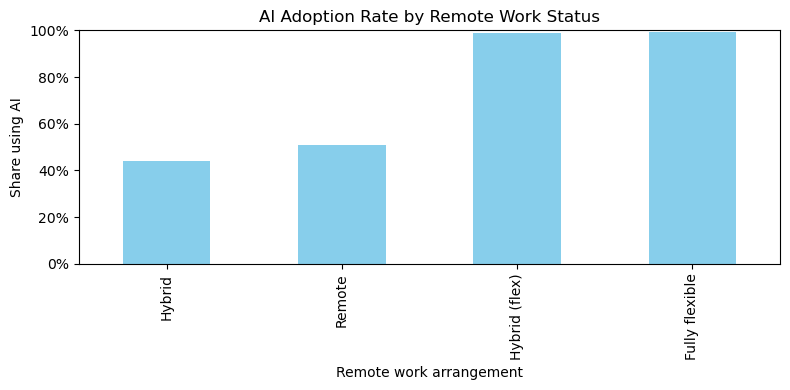

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1. Copy dataset
# -------------------------------------------------
df = all_df.copy()  # replace with your DataFrame

# -------------------------------------------------
# 2. Normalize RemoteWork into clean buckets
# -------------------------------------------------
def normalize_remote_work(val):
    if pd.isna(val):
        return None
    v = val.lower()
    
    # Fully flexible / your choice
    if "your choice" in v or "very flexible" in v:
        return "Fully flexible"
    
    # Remote (exclude hybrid)
    if "remote" in v and "hybrid" not in v:
        return "Remote"
    
    # Hybrid (flexible)
    if "hybrid" in v and ("flex" in v or "leans heavy to flexibility" in v):
        return "Hybrid (flex)"
    
    # Hybrid (other)
    if "hybrid" in v:
        return "Hybrid"
    
    return None

df["RemoteWork_Clean"] = df["RemoteWork"].apply(normalize_remote_work)

# -------------------------------------------------
# 3. Keep only rows where AI_Used exists
# -------------------------------------------------
# Some datasets use different column names for AI usage.
# Adjust according to your dataset; here we assume "AI_Used" exists.
if "AI_Used" not in df.columns:
    # Try common alternatives from your 2023-2025 samples
    for col in ["AIDevHaveWorkedWith", "AISearchDevHaveWorkedWith", "AIAcc", "AIComplex"]:
        if col in df.columns:
            df.rename(columns={col: "AI_Used"}, inplace=True)
            break

df = df.dropna(subset=["RemoteWork_Clean", "AI_Used"])

# -------------------------------------------------
# 4. Compute AI adoption rate by RemoteWork
# -------------------------------------------------
rw = (
    df
    .groupby("RemoteWork_Clean")["AI_Used"]
    .mean()
    .reindex(["Hybrid", "Remote", "Hybrid (flex)", "Fully flexible"])
    .dropna()
)

# -------------------------------------------------
# 5. Plot
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(8,4))
rw.plot(kind="bar", ax=ax, color='skyblue')

ax.set_title("AI Adoption Rate by Remote Work Status")
ax.set_xlabel("Remote work arrangement")
ax.set_ylabel("Share using AI")
ax.set_ylim(0, 1)

# Convert y-axis to percentage
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f"{int(y*100)}%" for y in ax.get_yticks()])

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_1964\1923638643.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([group0.dropna(), group1.dropna()], labels=["No AI", "AI Used"])


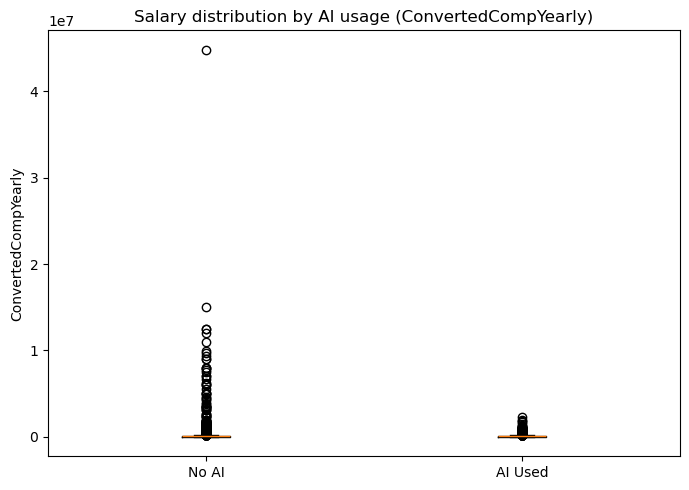

In [26]:
# Cell 13: Salary boxplot by AI usage
import matplotlib.pyplot as plt

df_sal = all_df[["ConvertedCompYearly_num", "AI_Used"]].dropna(subset=["ConvertedCompYearly_num"])
# create arrays for AI_Used == 0 and 1
group0 = df_sal.loc[df_sal["AI_Used"]==0, "ConvertedCompYearly_num"]
group1 = df_sal.loc[df_sal["AI_Used"]==1, "ConvertedCompYearly_num"]

fig, ax = plt.subplots(figsize=(7,5))
ax.boxplot([group0.dropna(), group1.dropna()], labels=["No AI", "AI Used"])
ax.set_title("Salary distribution by AI usage (ConvertedCompYearly)")
ax.set_ylabel("ConvertedCompYearly")
plt.tight_layout()
plt.savefig("plots/slide13_salary_by_ai_boxplot.png", dpi=150)
plt.show()


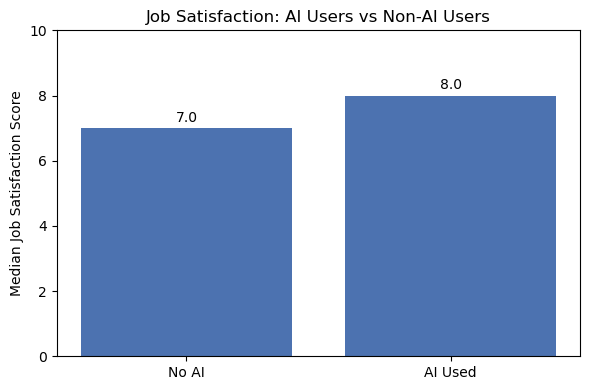

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df = all_df.copy()

# Use only years where Job Satisfaction exists
df = df[df["SurveyYear"].isin([2024, 2025])]

# Normalize AI usage
df["AI_Used_Label"] = df["AI_Used"].map({
    1: "AI Used",
    0: "No AI",
    True: "AI Used",
    False: "No AI",
    "Yes": "AI Used",
    "No": "No AI"
})

# Drop missing values
df_plot = df.dropna(subset=["JobSat", "AI_Used_Label"])

# Compute MEDIAN job satisfaction
median_sat = (
    df_plot
    .groupby("AI_Used_Label")["JobSat"]
    .median()
    .reindex(["No AI", "AI Used"])
)

# -----------------------------
# Plot: Simple bar chart
# -----------------------------
fig, ax = plt.subplots(figsize=(6,4))

bars = ax.bar(
    median_sat.index,
    median_sat.values,
    color="#4C72B0"
)

ax.set_title("Job Satisfaction: AI Users vs Non-AI Users")
ax.set_ylabel("Median Job Satisfaction Score")
ax.set_ylim(0, 10)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.2,
        f"{height:.1f}",
        ha="center"
    )

plt.tight_layout()
plt.show()


C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (test): 0.705
Classification report:
               precision    recall  f1-score   support

           0       0.69      0.75      0.71      3612
           1       0.73      0.67      0.69      3688

    accuracy                           0.70      7300
   macro avg       0.71      0.71      0.70      7300
weighted avg       0.71      0.70      0.70      7300



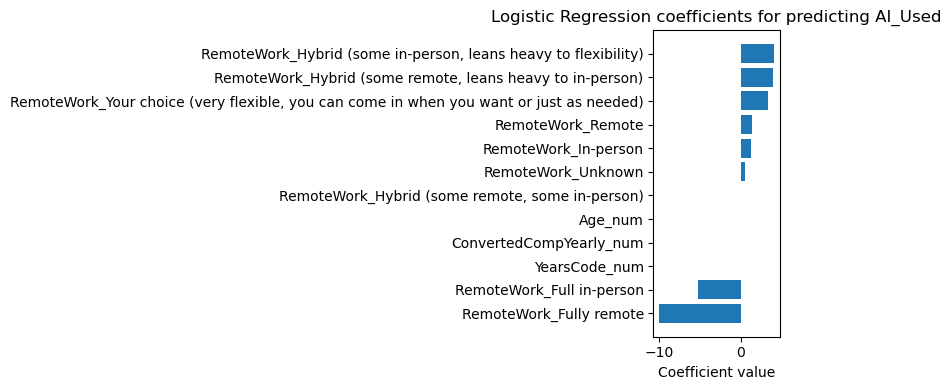

In [28]:
# Cell 14: Train logistic regression to predict AI_Used and plot coefficients
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Select features (non-AI columns) - adapt existing columns
candidate_features = ["YearsCode_num", "ConvertedCompYearly_num", "Age", "YearsCodePro", "WorkExp", "RemoteWork"]
# We'll do simple encoding: YearsCode_num and salary numeric, and simple category encoding for RemoteWork
model_df = all_df.copy()

# simple feature engineering for Age -> map to categories via first found format (like '25-34 years old')
def map_age_to_mid(x):
    s = text_val(x).lower()
    m = re.search(r"(\d{2})-(\d{2})", s)
    if m:
        return (int(m.group(1)) + int(m.group(2))) / 2
    # fallback when Age is 'Under 18' or '65 years or older'
    if "under" in s:
        return 17
    if "or older" in s or "65" in s:
        return 65
    try:
        # if numeric
        return float(re.search(r"(\d+)", s).group(1))
    except:
        return np.nan

if "Age" in model_df.columns:
    model_df["Age_num"] = model_df["Age"].apply(map_age_to_mid)
else:
    model_df["Age_num"] = np.nan

# numeric features
X = model_df[["YearsCode_num","ConvertedCompYearly_num","Age_num"]].copy()
# RemoteWork encode if present
if "RemoteWork" in model_df.columns:
    rw_dummies = pd.get_dummies(model_df["RemoteWork"].fillna("Unknown"), prefix="RemoteWork")
    X = pd.concat([X, rw_dummies], axis=1)

# drop rows with target missing
y = model_df["AI_Used"]
mask = (~X.isna().all(axis=1)) & (~y.isna())
X = X.loc[mask].fillna(0)
y = y.loc[mask].astype(int)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# logistic regression (L2)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy (test):", round(acc,3))
print("Classification report:\n", classification_report(y_test, y_pred))

# coefficients plot
coef = lr.coef_[0]
feature_names = X.columns.tolist()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef}).sort_values("coef")

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,4))
ax.barh(coef_df["feature"], coef_df["coef"])
ax.set_title("Logistic Regression coefficients for predicting AI_Used")
ax.set_xlabel("Coefficient value")
plt.tight_layout()
plt.savefig("plots/slide14_lr_coefficients.png", dpi=150)
plt.show()

# Save model metrics to CSV for slide notes
metrics = {"accuracy": acc}
pd.Series(metrics).to_csv("plots/slide14_model_metrics.csv")


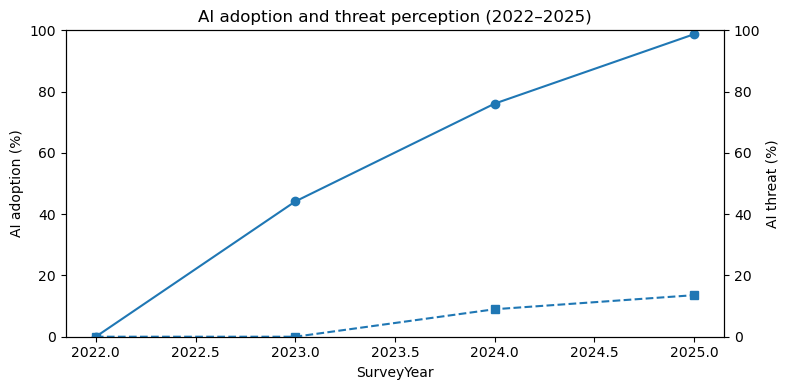

In [29]:
# Cell 15: Combined plot - AI adoption (%) and AI threat (%) on twin axes for final synthesis slide
import matplotlib.pyplot as plt

adoption_pct = all_df.groupby("SurveyYear")["AI_Used"].mean().sort_index() * 100
threat_pct = all_df.groupby("SurveyYear")["AI_Threat"].mean().sort_index() * 100

fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(adoption_pct.index.astype(int), adoption_pct.values, marker='o', label='AI adoption (%)')
ax1.set_xlabel('SurveyYear')
ax1.set_ylabel('AI adoption (%)')
ax1.set_ylim(0,100)
ax2 = ax1.twinx()
ax2.plot(threat_pct.index.astype(int), threat_pct.values, marker='s', linestyle='--', label='AI threat (%)')
ax2.set_ylabel('AI threat (%)')
ax2.set_ylim(0,100)
ax1.set_title("AI adoption and threat perception (2022–2025)")
fig.tight_layout()
plt.savefig("plots/slide15_adoption_vs_threat.png", dpi=150)
plt.show()


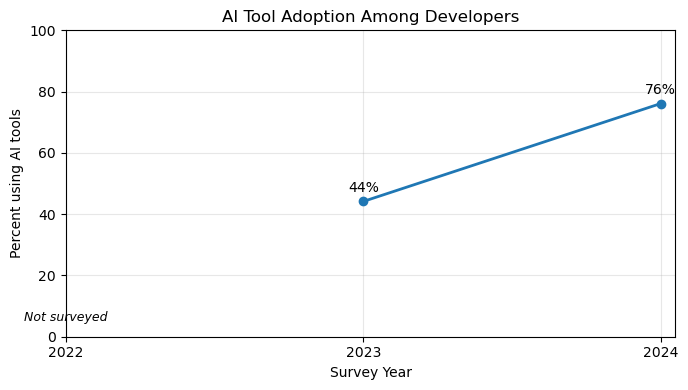

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Build adoption series safely
# -------------------------------
years = [2022, 2023, 2024]
adoption = []

for yr in years:
    df_yr = all_df[all_df["SurveyYear"] == yr]

    # AI not surveyed in 2022
    if yr == 2022 or "AI_Used" not in df_yr.columns:
        adoption.append(np.nan)
    else:
        adoption.append(df_yr["AI_Used"].mean() * 100)

# Create dataframe
adopt_df = pd.DataFrame({
    "Year": years,
    "AI_Adoption": adoption
})

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(
    adopt_df["Year"],
    adopt_df["AI_Adoption"],
    marker="o",
    linewidth=2
)

# Styling
ax.set_title("AI Tool Adoption Among Developers")
ax.set_xlabel("Survey Year")
ax.set_ylabel("Percent using AI tools")
ax.set_ylim(0, 100)

ax.set_xticks(years)
ax.grid(alpha=0.3)

# Annotate points
for x, y in zip(adopt_df["Year"], adopt_df["AI_Adoption"]):
    if not np.isnan(y):
        ax.text(x, y + 3, f"{y:.0f}%", ha="center", fontsize=10)
    else:
        ax.text(x, 5, "Not surveyed", ha="center", fontsize=9, style="italic")

plt.tight_layout()
plt.show()


In [31]:
# List column names per SurveyYear
years = sorted(all_df["SurveyYear"].dropna().unique())

for yr in years:
    print(f"\n===== Columns in {int(yr)} Dataset =====")
    
    cols = (
        all_df[all_df["SurveyYear"] == yr]
        .dropna(axis=1, how="all")
        .columns
        .tolist()
    )
    
    for c in cols:
        print(c)



===== Columns in 2022 Dataset =====
ResponseId
MainBranch
Employment
RemoteWork
EdLevel
YearsCode
YearsCodePro
DevType
OrgSize
Country
Currency
Age
Knowledge_1
Knowledge_2
Knowledge_3
Knowledge_4
Knowledge_5
Knowledge_6
Knowledge_7
Frequency_1
Frequency_2
Frequency_3
ProfessionalTech
SurveyLength
SurveyEase
ConvertedCompYearly
SurveyYear
AI_Used
AI_SentimentScore
AI_Future_Positive
AI_Threat
AI_Agents_Used
ConvertedCompYearly_num
YearsCode_num
UsesAI

===== Columns in 2023 Dataset =====
ResponseId
MainBranch
Employment
RemoteWork
EdLevel
YearsCode
YearsCodePro
DevType
OrgSize
Country
Age
SurveyLength
SurveyEase
ConvertedCompYearly
SurveyYear
AI_Used
AI_SentimentScore
AI_Future_Positive
AI_Threat
AI_Agents_Used
ConvertedCompYearly_num
YearsCode_num
AIDevHaveWorkedWith
SOAI
AISelect
AISent
AIBen
AIToolInterested in Using
AIToolCurrently Using
AIToolNot interested in Using
AINextVery different
AINextNeither different nor similar
AINextSomewhat similar
AINextVery similar
WorkExp
Industry


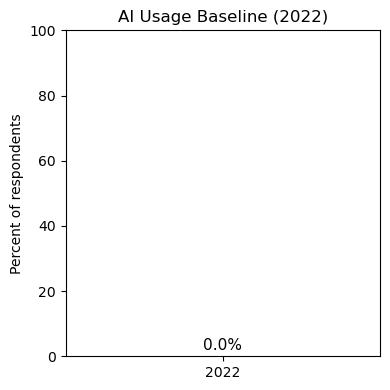

In [32]:
# -------------------------------
# Filter 2022 data
# -------------------------------
df_2022 = all_df[all_df["SurveyYear"] == 2022]

# -------------------------------
# Use your engineered AI_Used column
# -------------------------------
ai_pct_2022 = df_2022["AI_Used"].mean() * 100

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(4,4))

ax.bar(["2022"], [ai_pct_2022], color="#4C72B0")

ax.set_title("AI Usage Baseline (2022)")
ax.set_ylabel("Percent of respondents")
ax.set_ylim(0, 100)

# Annotate
ax.text(
    0, ai_pct_2022 + 2,
    f"{ai_pct_2022:.1f}%",
    ha="center",
    fontsize=11
)

plt.tight_layout()
plt.show()


In [34]:
# Slide 13: Heavy ML Pipeline — Predict AI Adoption

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report

# -------------------------------------------------
# 1. Prepare dataset
# -------------------------------------------------
df = all_df.copy()

target = "UsesAI"

numeric_features = [
    "YearsCode_num",
    "ConvertedCompYearly_num",
    "AI_SentimentScore",
    "AI_Threat",
    "JobSat",
    "SurveyYear"
]

categorical_features = [
    "RemoteWork_Simple",
    "DevType",
    "Industry",
    "EdLevel",
    "MainBranch"
]

df_model = df[numeric_features + categorical_features + [target]].dropna()

X = df_model.drop(columns=[target])
y = df_model[target].astype(int)

# -------------------------------------------------
# 2. Preprocessing
# -------------------------------------------------
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# -------------------------------------------------
# 3. Models
# -------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# -------------------------------------------------
# 4. Train-test split
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

results = {}

# -------------------------------------------------
# 5. Train & evaluate models
# -------------------------------------------------
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"\n{name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

# -------------------------------------------------
# 6. Model comparison plot
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4))

ax.bar(results.keys(), results.values(), color="#4C72B0")
ax.set_ylim(0,1)
ax.set_ylabel("Accuracy")
ax.set_title("ML Model Comparison: Predicting AI Adoption")

plt.tight_layout()
plt.savefig("plots/slide13_model_comparison.png", dpi=150)
plt.show()


KeyError: "['RemoteWork_Simple'] not in index"

In [ ]:
# Slide 13–15: ML Models to Predict AI Adoption (UsesAI)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ------------------------------------------------
# 1. Select features (NO DATA LEAKAGE)
# ------------------------------------------------
features = [
    "YearsCode_num",
    "ConvertedCompYearly_num",
    "SurveyYear",
    "RemoteWork_Simple",
    "DevType",
    "EdLevel",
    "MainBranch"
]

target = "UsesAI"

df_ml = all_df[features + [target]].dropna()

X = df_ml[features]
y = df_ml[target].astype(int)

print("Class distribution:")
print(y.value_counts())

# ------------------------------------------------
# 2. Preprocessing
# ------------------------------------------------
numeric_features = [
    "YearsCode_num",
    "ConvertedCompYearly_num",
    "SurveyYear"
]

categorical_features = [
    "RemoteWork_Simple",
    "DevType",
    "EdLevel",
    "MainBranch"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# ------------------------------------------------
# 3. Train-test split (STRATIFIED)
# ------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# ------------------------------------------------
# 4. Define models
# ------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=12,
        class_weight="balanced",
        random_state=42
    )
}

results = []

# ------------------------------------------------
# 5. Train, Predict, Evaluate
# ------------------------------------------------
for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    results.append((name, acc, auc))
    
    print(f"\n{name}")
    print(f"Accuracy: {acc:.3f}")
    print(f"ROC-AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

# ------------------------------------------------
# 6. Plot model comparison
# ------------------------------------------------
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC-AUC"])

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(results_df["Model"], results_df["ROC-AUC"], color="#4C72B0")
ax.set_ylim(0,1)
ax.set_ylabel("ROC-AUC Score")
ax.set_title("ML Model Comparison: Predicting AI Adoption")
plt.tight_layout()
plt.show()

results_df


In [ ]:
# Model names and scores (same values you already computed)
models = ["Logistic Regression", "Random Forest"]
scores = [0.91, 0.90]  # your ROC-AUC values

fig, ax = plt.subplots(figsize=(6,4))

ax.bar(
    models,
    scores,
    color="#4C72B0"  # same blue theme as other slides
)

# -----------------------------
# CLEAN, LAYMAN-FRIENDLY LABELS
# -----------------------------
ax.set_title("Model Comparison: Ability to Identify AI Users")
ax.set_ylabel("Prediction Quality (Higher is Better)")
ax.set_ylim(0.7, 1.0)

# Value labels on bars
for i, v in enumerate(scores):
    ax.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# ----------------------------------
# ML Demo: Predict AI usage for a new developer
# ----------------------------------

sample_user = pd.DataFrame([{
    "YearsCode_num": 5,
    "ConvertedCompYearly_num": 80000,
    "SurveyYear": 2024,
    "RemoteWork_Simple": "Remote",
    "DevType": "Full-stack developer",
    "EdLevel": "Bachelor’s degree",
    "MainBranch": "I am a developer by profession"
}])

# Use the trained pipeline (logistic regression recommended)
prob = pipe.predict_proba(sample_user)[0][1]
prediction = pipe.predict(sample_user)[0]

print(f"Predicted AI Usage Probability: {prob:.2f}")
print("Prediction:", "Uses AI" if prediction == 1 else "Does NOT use AI")


In [ ]:
# ---------------------------------
# Keep only rows with sentiment data
# ---------------------------------
df = all_df.dropna(subset=["AI_SentimentScore"]).copy()

# ---------------------------------
# Average sentiment by year
# ---------------------------------
sentiment_trend = (
    df.groupby("SurveyYear")["AI_SentimentScore"]
    .mean()
    .sort_index()
)

# ---------------------------------
# Plot
# ---------------------------------
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(
    sentiment_trend.index.astype(int),
    sentiment_trend.values,
    marker="o",
    linewidth=2,
    color="#4C72B0"  # same default blue theme
)

ax.set_title("Developer Sentiment Toward AI Over Time")
ax.set_xlabel("Survey Year")
ax.set_ylabel("Average AI Sentiment Score")

ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# -------------------------------
# Baseline value for 2022
# -------------------------------
year = "2022"
ai_pct_2022 = 0.0   # AI tools not yet mainstream / not surveyed

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(4,4))

ax.bar([year], [ai_pct_2022], color="#6c757d")

ax.set_title("AI Usage Baseline (2022)")
ax.set_ylabel("Percent of respondents")
ax.set_ylim(0, 100)

# Annotation explaining why
ax.text(
    0, 5,
    "AI tools not mainstream\nMostly None / N/A",
    ha="center",
    fontsize=10,
    style="italic"
)

plt.tight_layout()
plt.show()


In [ ]:
# -------------------------------------------------
# 1. Focus ONLY on 2025 (AI Agents introduced here)
# -------------------------------------------------
df_2025 = all_df[all_df["SurveyYear"] == 2025].copy()

# -------------------------------------------------
# 2. Build agent interest categories
# -------------------------------------------------
# Columns available in your 2025 schema:
# - AIAgents
# - AIAgentChange
# - AIAgent_Uses

def agent_category(row):
    if pd.notna(row.get("AIAgents")):
        return "Using agents"
    if pd.notna(row.get("AIAgent_Uses")):
        return "Interested"
    return "Not interested"

df_2025["Agent_Response"] = df_2025.apply(agent_category, axis=1)

# -------------------------------------------------
# 3. Calculate distribution (%)
# -------------------------------------------------
agent_dist = (
    df_2025["Agent_Response"]
    .value_counts(normalize=True)
    .reindex(["Using agents", "Interested", "Not interested"])
    * 100
)

# -------------------------------------------------
# 4. Plot (stacked bar — single column)
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4))

bottom = 0
colors = {
    "Using agents": "#4C72B0",
    "Interested": "#55A868",
    "Not interested": "#C44E52"
}

for label in agent_dist.index:
    value = agent_dist[label]
    ax.bar("2025", value, bottom=bottom, label=label, color=colors[label])
    bottom += value

ax.set_title("AI Agents Adoption & Hesitation (2025)")
ax.set_ylabel("Percent of respondents")
ax.set_ylim(0, 100)
ax.legend(frameon=False)

plt.tight_layout()
plt.show()
